In [1]:
import time
import numpy as np

import math
import matplotlib.pyplot as plt
from multiprocessing import Pool
import random
import timeit
import copy
import pandas as pd
import warnings
import scipy.integrate as integrate
warnings.filterwarnings('ignore')
import sys,os
sys.path.append(os.path.abspath("../"))
from LBL_funcs_waterRTM import *
import re
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from scipy.special import erf

## the blackbody

In [2]:
import scipy.integrate as integrate

dnu = 5 # spectral resolutio
nu = np.arange(0, 33333+dnu,dnu)  # cm-1
nu1 = np.arange(0, 33333+dnu,dnu)  # cm-1
nu = np.delete(nu, 0)
nu = np.insert(nu,0,1)
nu1 = np.delete(nu1, 0)
nu1 = np.insert(nu1,0,1)
# wavelength [um]
# a = 1/nu*1e4  # cm-1 -> um
# lam = a[::-1]  # um
# generate x-axis in increments from 1nm to 3 micrometer in 1 nm increments
# starting at 1 nm to avoid wav = 0, which would result in division by zero.
wavelengths = np.arange(1e-9, 10e-6, 1e-9) * 1e6

T = np.arange(1400,2300+100,100)  # K
#T = np.append(300,T)

F_dw_os = np.zeros([T.shape[0], nu.shape[0]])
Intens = np.zeros(T.shape[0])

for tt in range(T.shape[0]):
    # wave number
    F_dw_os[tt] = Planck(nu,T[tt])*math.pi
    #F_dw[tt] = Planck_lam(wavelengths,T[tt])#*math.pi
    #Intens[tt] = integrate.trapz(F_dw[tt], wavelengths)
    Intens[tt] = integrate.trapz(F_dw_os[tt], nu)
# the energy on TOW is F_dw_os, and the total is Intens
print(T)

[1400 1500 1600 1700 1800 1900 2000 2100 2200 2300]


In [3]:
#1.14 um
p_nu=1754 # 
print(1/nu[1754:1756]) # 1754 is closer to 1.14 um
n = nu[p_nu] 
print(n)
print(f'lamb={1/n*1e4}')
pnu=-1

[0.00011403 0.00011396]
8770
lamb=1.1402508551881414


## extract file

In [4]:
def calculateF(res,nu1,lamb,p_nu):
    # lamb = piece-wise
    # lamb=1 Wavelength ≤ 10000
    # lamb=0 wavelength ≤ 10000
    if lamb == 1:
        nu = nu1[:p_nu]
        items1 = ['F_n_abs', 'F_n_abs_rights','F_n_abs_leftn','F_n_abs_fronte','F_n_abs_backw']
        F_total = 0
        for item in items1:
            temp = res.item().get(item)
            F_i = integrate.trapz(temp[:,:p_nu], nu, axis=1)
            F_total += np.sum(F_i)
    if lamb == 0:
        nu = nu1[p_nu:]
        items1 = ['F_n_abs', 'F_n_abs_rights','F_n_abs_leftn','F_n_abs_fronte','F_n_abs_backw']
        F_total = 0
        for item in items1:
            temp = res.item().get(item)
            F_i = integrate.trapz(temp[:,p_nu:], nu, axis=1)
            F_total += np.sum(F_i)
    F_gas = res.item().get('F_n_abs')
    N_layer = F_gas.shape[0]
    F_1stLayer = res.item().get("F_n_abs")[-2]
    F_body = res.item().get("F_n_abs")[1:-2]
    F_edge = res.item().get('F_n_abs_rights') + res.item().get('F_n_abs_leftn') \
             + res.item().get('F_n_abs_fronte') + res.item().get('F_n_abs_backw')
    F_bottom= res.item().get('F_n_abs')[0]
    F_dw = res.item().get('F_n_dw')
    F_uw = res.item().get('F_n_uw')
    if lamb == 1:
        return F_total, F_bottom[:p_nu], F_1stLayer[:p_nu], F_body[:,:p_nu],\
               F_edge[:,:p_nu] #F_dw[:,:p_nu], F_uw[:,:p_nu]
    if lamb == 0:
        return F_total, F_bottom[p_nu:], F_1stLayer[p_nu:], F_body[:,p_nu:],\
               F_edge[:,p_nu:] # F_dw[:,p_nu:], F_uw[:,p_nu:]
    
def check_convergence(y, mean):
    diff = [np.nan]
    for i in range(1, len(y)):
        dy = abs(y[i] - y[i-1])
        diff.append(1-dy/mean*100)
    return diff

depth = 0.5
width = 1
long = 1
#path = "./randangle/"
path = './Tdepth/'
Fls = os.listdir(path) #+ os.listdir(path2)

dnu = 5 # spectral resolutio
nu = np.arange(0, 33333+dnu,dnu)  # cm-1
nu = np.delete(nu,0)
nu = np.insert(nu,0,1)

# all files.npy in the folder
Fls = [s for s in Fls if s.endswith('.npy')]
len(Fls)

160

In [5]:
import re
layers = []
Temp = []
for string in Fls:
    #match = re.search(r'_([\d.]+)layer', string)
    match = re.search(r'_([\d.]+)layer', string)
    if match:
        number = int(match.group(1))
        layers.append(number)
    match = re.search(r'([\d.]+)_results', string)
    if match:
        Temp.append(int(match.group(1)))
df1 = pd.DataFrame({"Temp":Temp,"layer":layers})
print(nu.shape)
df1['F_dw'] = df1.apply(lambda row:Planck(nu,row['Temp'])*math.pi, axis=1)

(6668,)


In [6]:
lamb = 0
# 2. extract all kinds of energy and save it as pandas
# allocate a empty dataframe
df2 = pd.DataFrame(columns=["F_total","F_bottom","F_1stLayer","F_body","F_edge"])#,"F_dw","F_uw"])
for i in range(len(Fls)):
    try:
        res = np.load(path+Fls[i], allow_pickle=True)
    except:
        res = np.load(path2+Fls[i], allow_pickle=True)
    columns = ["F_total", "F_bottom", "F_1stLayer", "F_body", "F_edge"]# "F_dw", "F_uw"]
    values = calculateF(res, nu, lamb, p_nu)
    df2.loc[i, columns] = values
df = pd.concat([df1, df2], axis=1)
del df1, df2

if lamb == 1:
    nu = nu[:p_nu]
else:
    nu = nu[p_nu:]
#df = dataf.sort_values(by='Temp')
df.iloc[0]['F_dw'].shape

(6668,)

### import coeff

In [7]:
# the energy on TOW is F_dw_os, and the total is Intens
import scipy.integrate as integrate
temp1 = df['F_body'].apply(lambda x:integrate.trapz(x,nu,axis=1))

#temp2 = df['F_dw'].apply(lambda x:integrate.trapz(x[-1],nu)).values  # the transmitted energy!
dnu = 5 # spectral resolutio
nuii = np.arange(0, 33333+dnu,dnu)
nuii = np.delete(nuii,0)
nuii = np.insert(nuii,0,1)

temp2 = df['F_dw'].apply(lambda x:integrate.trapz(x,nuii)).values

temp3 = df['F_1stLayer'].apply(lambda x: integrate.trapz(x,nu)).values/temp2
df['body']=temp1/temp2

for i in range (len(temp3)):
    temp =np.append(df['body'][i],temp3[i])
    df['body'][i]=temp  ## since then df['body'] includes the first layer

In [8]:
df =df.sort_values(by='Temp')
# body's depth
df['z'] = df['layer'].apply(lambda x: np.linspace(1,x,x)) 
df['int_abs'] = df['body'].apply(lambda x: np.cumsum(x[::-1]))  

# Piecewise

In [9]:
import numpy as np
from scipy.optimize import curve_fit, differential_evolution

## collect c1,c2,c2

In [10]:
def sort_indices(x0,y0):
    sort_indices = np.argsort(y0)
    x_sorted = x0[sort_indices]
    y_sorted = y0[sort_indices]
    return x_sorted,y_sorted
# for the target specturm, when depth > 50cm, 
# all the absorption rate equals to 1, 
# there is no need for plot them out.
cd=0.5 # 50 cm
T[:]

array([1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300])

Mean R2:0.962862654090684


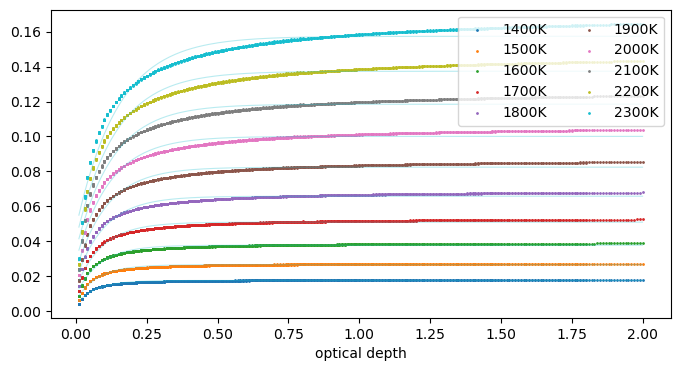

In [11]:
C1 = []
C2 = []
C3 = []
C4 = []
C5 = []
Tf = []

def func(x, c1,c2,c3):
    return 1-np.exp(-c1*x+c2)+c3 # 0.99, 
TR2 = []

fig, axs = plt.subplots(1,1,figsize=(8,4))
i=0
for tttt in T:
    df5800 = df[df['Temp']==tttt]
    df5800 = df5800.sort_values(by='layer')
    for index, row in df5800.iterrows():
        z = row['z']
        x = z/100 #*row['k_ave']/1e4
        y = row['int_abs']
        # No absorption when x=0
        if row['layer']==30:
            x_r = x[:-3]
            y_r = y[:-3]
        #x = np.insert(x, 0, 0)
        #y = np.insert(y, 0, 0)
        x_r = np.concatenate((x_r,x))
        y_r = np.concatenate((y_r,y))

    y_r1 = y_r[x_r<=20]
    x_r1 = x_r[x_r<=20]
    #y_r1 = y_r
    #x_r1 = x_r

    initial_guess = [0,0,0]
    params, params_covariance = curve_fit(func, x_r1, y_r1, p0=initial_guess,maxfev=8000)
    c1,c2,c3 = params
    y1 = func(x_r1,c1,c2,c3)
    # ------ plot -------- # 
    axs.scatter(x_r1,y_r1,s=1,color=f'C{i}',label=f'{tttt}K')
    x_i,y0 = sort_indices(x_r1,y1)
    axs.plot(x_i,y0,alpha=0.3,color='C9',linewidth=0.8)
    plt.xlabel('optical depth')

    i = i+1

    temp = r2_score(y1, y_r1)
    #print("R2",temp)
    TR2.append(temp)

    # print("T=", tttt)
    # print("Fitted c1 = ", c1)
    # print("Fitted c2 = ", c2)
    # print("Fitted c3 = ", c3)
    # print("Fitted c4 = ", c4)
    #Piece.append(j+1)
    Tf.append(tttt)
    C1.append(c1)
    C2.append(c2)
    C3.append(c3)

#print(f'Piece {j}:')
print('Mean R2:'+ f'{np.mean(np.array(TR2))}')
plt.legend(ncol=2)
plt.show()

In [12]:
print('Tf=',Tf)
print('C1:  '+', '.join('{:.5f}'.format(value) for value in C1))
print('C2:  '+', '.join('{:.4f}'.format(value) for value in C2))
print('C3:  '+', '.join('{:.4f}'.format(value) for value in C3))
#print('C4:  '+', '.join('{:.4f}'.format(value) for value in C4))
#print('C5:  '+', '.join('{:.4f}'.format(value) for value in C5))

Tf = np.array(Tf)
C1 = np.array(C1)
C2 = np.array(C2)
C3 = np.array(C3)
#print('C1=',C1)
#print('C2=',C2)

Tf= [1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300]
C1:  14.18933, 12.94856, 11.81350, 10.79211, 9.86346, 9.08470, 8.38366, 7.77053, 7.23454, 6.75077
C2:  -4.3006, -3.9053, -3.5715, -3.2871, -3.0464, -2.8314, -2.6473, -2.4861, -2.3444, -2.2116
C3:  -0.9824, -0.9734, -0.9622, -0.9490, -0.9342, -0.9176, -0.9000, -0.8815, -0.8627, -0.8427


### fit c1,c2,c2 and T

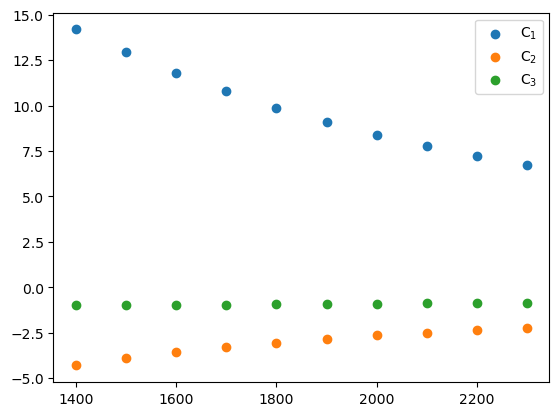

In [13]:
plt.scatter(Tf,C1,label=r"$\mathrm{C}_1$")
plt.scatter(Tf,C2,label="$\mathrm{C}_2$")
plt.scatter(Tf,C3,label="$\mathrm{C}_3$")
plt.legend()
plt.show()

###  $C1 = a1*T^2+b1*T+c1$

In [14]:
import numpy as np
from scipy.optimize import curve_fit, differential_evolution

def func(x, a,b,c):
    return a*x**2+b*x+c

# provide initial guess
initial_guess = [0,0,0]

# perform the curve fit
params, params_covariance = curve_fit(func, np.array(Tf)/1e4, C1, p0=initial_guess,maxfev=100000)

# params[0] will contain the fitted value of A, params[1] the value of B
a1,b1,c1 = params

print("Fitted a1 = ", a1)
print("Fitted b1 = ", b1)
print("Fitted b1 = ", c1)
print("{:.5f}*x**2+{:.5f}*x+{:.5f}".format(a1,b1,c1))

Fitted a1 =  496.3198614043007
Fitted b1 =  -265.5560168446026
Fitted b1 =  41.61496777600186
496.31986*x**2+-265.55602*x+41.61497


###  $C2 = a2*T^2+b2*T+c2$

In [15]:
import numpy as np
from scipy.optimize import curve_fit, differential_evolution

def func(x, a,b,c):
    #return c
    return a*x**2+b*x+c

# provide initial guess
initial_guess = [0,0,0]

# perform the curve fit
params, params_covariance = curve_fit(func, np.array(Tf)/1e4, C2, p0=initial_guess,maxfev=100000)

# params[0] will contain the fitted value of A, params[1] the value of B
a2,b2,c2 = params

print("Fitted a2 = ", a2)
print("Fitted b2 = ", b2)
print("Fitted c2 = ", c2)
print("{:.5f}*x**2+{:.5f}*x+{:.5f}".format(a2,b2,c2))

Fitted a2 =  -159.0987568630004
Fitted b2 =  81.46561558667679
Fitted c2 =  -12.557901657805859
-159.09876*x**2+81.46562*x+-12.55790


In [16]:
import numpy as np
from scipy.optimize import curve_fit, differential_evolution

def func(x, a,b,c):
    return a*x**2+b*x+c

# provide initial guess
initial_guess = [1,1,1]

# perform the curve fit
params, params_covariance = curve_fit(func, np.array(Tf)/1e4, C3, p0=initial_guess,maxfev=100000)

# params[0] will contain the fitted value of A, params[1] the value of B
a3,b3,c3 = params

print("Fitted a3 = ", a3)
print("Fitted b3 = ", b3)
print("Fitted c3 = ", c3)
print("{:.5f}*x**2+{:.5f}*x+{:.5f}".format(a3,b3,c3))

Fitted a3 =  6.642337177991734
Fitted b3 =  -0.8817934117290406
Fitted c3 =  -0.9902513910173721
6.64234*x**2+-0.88179*x+-0.99025


###  $C4 = a2*T^2+b2*T+c2$

In [ ]:
import numpy as np
from scipy.optimize import curve_fit, differential_evolution

def func(x, a,b,c):
    return c
    #return a*x**2+b*x+c

# provide initial guess
initial_guess = [0,0,0]

# perform the curve fit
params, params_covariance = curve_fit(func, np.array(Tf)/1e4, C4, p0=initial_guess,maxfev=100000)

# params[0] will contain the fitted value of A, params[1] the value of B
a4,b4,c4 = params

print("Fitted a2 = ", a4)
print("Fitted b2 = ", b4)
print("Fitted c2 = ", c4)
print("{:.5f}*x**2+{:.5f}*x+{:.5f}".format(a4,b4,c4))

### R2 of c1,c2,c3

In [17]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

font = 13
fontfml = 'Times New Roman'
plt.rcParams['font.size'] = font
plt.rcParams['font.family'] = fontfml
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['mathtext.rm'] =fontfml
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'
#plt.rcParams['text.usetex'] = True

# remove default bold font setting--run only on Linux server
import matplotlib as mpl
#del mpl.font_manager.weight_dict['roman']
#mpl.font_manager._rebuild()

In [18]:
T

array([1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300])

496.31986*x**2+-265.55602*x+41.61497
-159.09876*x**2+81.46562*x+-12.55790
6.64234*x**2+-0.88179*x+-0.99025
[0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23]
R2 of C1: 0.9998838797927387
R2 of C2: 0.9991787249829718
R2 of C3: 0.9997019530566049


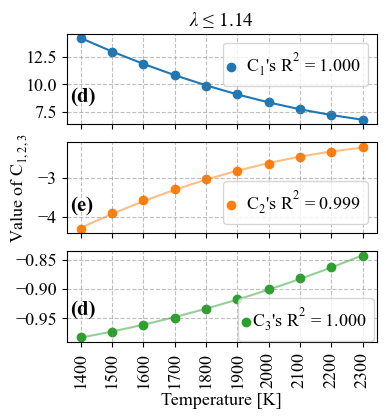

In [19]:
def func(x, a,b,c):
    return a*x**2+b*x+c

fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(3, 1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])

initial_guess = [0,0,0]
params, params_covariance = curve_fit(func, np.array(Tf)/1e4, C1, p0=initial_guess,maxfev=100000)
a1,b1,c1 = params
print("{:.5f}*x**2+{:.5f}*x+{:.5f}".format(a1,b1,c1))
initial_guess = [0,0,0]
params, params_covariance = curve_fit(func, np.array(Tf)/1e4, C2, p0=initial_guess,maxfev=100000)
a2,b2,c2 = params
print("{:.5f}*x**2+{:.5f}*x+{:.5f}".format(a2,b2,c2))
initial_guess = [0,0,0]
params, params_covariance = curve_fit(func, np.array(Tf)/1e4, C3, p0=initial_guess,maxfev=100000)
a3,b3,c3 = params
print("{:.5f}*x**2+{:.5f}*x+{:.5f}".format(a3,b3,c3))

tp = np.array(Tf)
tt = tp/1e4
print(tt)
#cc1 = a1*tt+b1
cc1 = a1*tt**2 + b1*tt + c1
cc2 = a2*tt**2 + b2*tt + c2 
cc3 = a3*tt**2 + b3*tt + c3

ax=axs

ax1.plot(tp,cc1, color="C0")
ax2.plot(tp,cc2,alpha=0.5, color="C1")
ax3.plot(tp,cc3,alpha=0.5, color="C2")

# Calculate R^2
print("R2 of C1:",r2_score(cc1, C1))
print("R2 of C2:",r2_score(cc2, C2))
print("R2 of C3:",r2_score(cc3, C3))


ax1.scatter(Tf,C1,color="C0",
            label=r"$\mathrm{C}_1$'s $\mathrm{R}^2$ = "+"{:.3f}".format(r2_score(cc1, C1)))
ax2.scatter(Tf,C2,color="C1",
            label="$\mathrm{C}_2$'s $\mathrm{R}^2$ = "+"{:.3f}".format(r2_score(cc2, C2)))
ax3.scatter(Tf,C3,color="C2",
            label="$\mathrm{C}_3$'s $\mathrm{R}^2$ = "+"{:.3f}".format(r2_score(cc3, C3)))

ax1.xaxis.grid(True, linestyle='--', which='both', color='grey', alpha=.5)
ax1.yaxis.grid(True, linestyle='--', which='both', color='grey', alpha=.5)

ax2.xaxis.grid(True, linestyle='--', which='both', color='grey', alpha=.5)
ax2.yaxis.grid(True, linestyle='--', which='both', color='grey', alpha=.5)

ax3.xaxis.grid(True, linestyle='--', which='both', color='grey', alpha=.5)
ax3.yaxis.grid(True, linestyle='--', which='both', color='grey', alpha=.5)

ax1.legend(loc='upper right',handlelength=0.05)
ax2.legend(loc='lower right',handlelength=0.05)
ax3.legend(loc='lower right',handlelength=0.05,handletextpad=0.3,bbox_to_anchor=(1.02, -0.09))

#leg.set_bbox_to_anchor([0, 0.62, 0.55, 0])
xlabel = T
ax1.set_xticks(np.array(xlabel))
ax1.set_xticklabels([])
ax2.set_xticks(np.array(xlabel))
ax2.set_xticklabels([])
ax3.set_xticks(np.array(xlabel))


ax1.text(0.01, 0.25, '(d)', transform=ax1.transAxes,fontsize=font+2,fontfamily=fontfml, weight='bold')
ax2.text(0.01, 0.25, '(e)', transform=ax2.transAxes,fontsize=font+2,fontfamily=fontfml, weight='bold')
ax3.text(0.01, 0.3, '(d)', transform=ax3.transAxes,fontsize=font+2,fontfamily=fontfml, weight='bold')

ax1.set_title(f'$\lambda$ ≤ {1/nu[0]*1e4:.2f}',fontsize=font+1)
ax3.set_xlabel('Temperature [K]')

ax2.set_ylabel(r"Value of $\mathrm{C}_{1,2,3}$")
plt.xticks(rotation=90)

plt.show()
fig_dir = '../figure/Fit_T_depth/'
fig.savefig(fig_dir+'R_abs_lowT_sw.png', dpi=300, bbox_inches='tight')

In [20]:
Tf

array([1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300])

### final result

In [21]:
sc = 5
cd  # 50 cm 

0.5

In [27]:
Tf=Tf[::-1]

2
2300K, R2:0.031810678259172574
2200K, R2:0.03135119232391848
2100K, R2:0.03236810300934989
2000K, R2:0.031712909968851614
1900K, R2:0.0288850700771817
1800K, R2:0.026327280232836803
1700K, R2:0.027188011198989715
1600K, R2:0.030903443979340344
1500K, R2:0.0219990883668193
1400K, R2:0.07624327281916321
mean R2: 0.03387890502356237


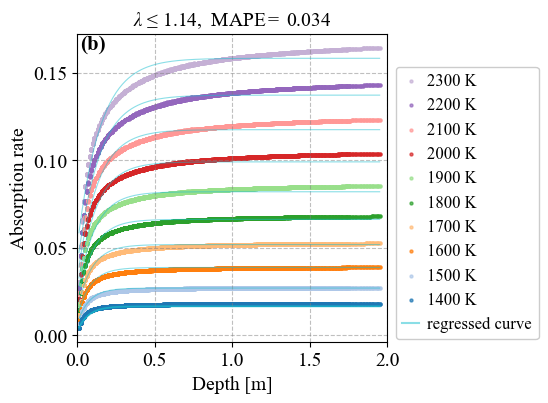

In [30]:
cmap = plt.get_cmap("tab20")

# Set default font family and font size
plt.rcParams['font.family'] = 'Times New Roman'  # For example, set font to Arial
plt.rcParams['font.size'] = 14  # 

TR_p = []

fig, ax = plt.subplots(1,figsize=(4,4))
for p in range(1):
    p=p+2  # the second kind of plotting method, line for regressed funcs.
    print(p)
    # initial_guess = [1,1,0]
    # params, params_covariance = curve_fit(func, np.array(Tf)/1e4, C1, p0=initial_guess,maxfev=100000)
    # a1,b1,c1 = params
    # initial_guess = [0,0,0]
    # params, params_covariance = curve_fit(func, np.array(Tf)/1e4, C2, p0=initial_guess,maxfev=100000)
    # a2,b2,c2 = params
    # initial_guess = [0,0,0]
    # params, params_covariance = curve_fit(func, np.array(Tf)/1e4, C3, p0=initial_guess,maxfev=100000)
    # a3,b3,c3 = params
    i=9
    #ax=axs[p-1]
    #ax=axs[0]
    for tp in Tf:
        dff = df[df['Temp']==tp]
        dff = dff.sort_values(by='layer')
        # Loop through each row
        for index, row in dff.iterrows():
            z = row['z']
            x = z /1e2 #*row['k_ave']/1e4
            y = row['int_abs']

            tt = tp/1e4
            cc1 = a1*tt**2 + b1*tt + c1
            cc2 = a2*tt**2 + b2*tt + c2
            cc3 = a3*tt**2 + b3*tt + c3

            if row['layer']==30:
                y_r = y[:-5]
                x_r = x[:-5]
            else:
                x_r = np.concatenate((x_r,x[:-5]))
                y_r = np.concatenate((y_r,y[:-5]))

        y_r1 = y_r#[x_r<=cd]  # 50 cm
        x_r1 = x_r#[x_r<=cd]

        yf = 1-np.exp(-cc1*x_r1+cc2)+cc3
        # Get the indices that would sort y
        sort_indices = np.argsort(yf)
        x_sorted = x_r1[sort_indices]
        y_sorted = yf[sort_indices]
        #ax.scatter(x_r1, yf, s=sc,alpha=0.5, color=cmap(18)) # label=rf"{tp}\degreeC")
        ax.plot(x_sorted, y_sorted, alpha=0.5, color=cmap(18),linewidth=0.8)
        ax.scatter(x_r1, y_r1, s=sc-0.5, alpha=0.7, color=cmap(i)) # label=rf"{tp}\degreeC")
        #print(y_f1.shape)
        #print(y_r1.shape)
        #temp = r2_score(yf, y_r1)
        temp = mean_absolute_percentage_error(yf, y_r1)
        #temp = np.sqrt(mean_squared_error(yf, y_r1))
        #temp = sqrt(temp)
        
        print(f"{tp}K, R2:{temp}")
        if p==1:
            ax.scatter(x_r1, y_r1, s=sc-0.5, alpha=0.7, color=cmap(i))#,label=rf"{tp} K")
        else:
            ax.scatter(x_r1, y_r1, s=sc-0.5, alpha=0.7, color=cmap(i),label=rf"{tp} K")
        TR_p.append(temp)
        #i=i+1
        i=i-1
    print("mean R2:",np.mean(np.array(TR_p)))
    
    if p==1:
        ax.plot(x_r1, yf,alpha=0.5, color=cmap(18), label="regressed curve")
        ax.scatter(x_r1, y_r1, s=sc, alpha=0.7, color=cmap(i-1)) # make last one front
    else:
        sort_indices = np.argsort(yf)
        x_sorted = x_r1[sort_indices]
        y_sorted = yf[sort_indices]
        ax.plot(x_sorted, y_sorted, alpha=0.5, color=cmap(18), label="regressed curve")
        #ax.plot(x_sorted, y_sorted, alpha=0.5, color=f'C9')
        ax.scatter(x_r1, y_r1, s=sc-0.5, alpha=0.7, color=cmap(i-1)) # make last one front

    ax.xaxis.grid(True, linestyle='--', which='both', color='grey', alpha=.5)
    ax.yaxis.grid(True, linestyle='--', which='both', color='grey', alpha=.5)

    ax.set_xlabel(r'Depth [m]')
    ax.set_ylabel('Absorption rate')

leg = ax.legend(ncol=1,columnspacing=0.8,framealpha=1,
                handlelength=1, handletextpad=0.5,
                fontsize=font-1,bbox_to_anchor=(1, 0.92), bbox_transform=ax.transAxes)
ax.set_xlim(0,2)

ax.set_title(f'$\lambda$ ≤ {1/nu[0]*1e4:.2f}, $~$MAPE$=~{np.mean(np.array(TR_p)):.3f}$',fontsize=font+1)
ax.text(0.01, 0.95, '(b)', transform=ax.transAxes,fontsize=font+2,fontfamily=fontfml,weight='bold')
fig_dir = "../figure/Fit_T_depth/"

fig.savefig(fig_dir+'R_abs_depth_lowT_sw.png', dpi=300, bbox_inches='tight',transparent=True)
plt.show()

0.08cm: 0.769,0.835
0.06cm: 0.8,0.85
0.06cm: 0.836,0.88

The absorption rate is followed the beer's law. 
The last element is the last layer above the bottom, it receive the reflected energy, thus there are abnormal steep over there for the last several layers.


the general $$y = 1- e^{-c_1*x+c_2}+c3$$

$$\int e^x dx=e^x + C$$

Fitted c1 =  1.04655*$x^2$ -1.04854 * x + 0.30797,  that is y=$(x−0.50047)^2$+0.04449

Fitted c2 =  -0.4124231351952815

Fitted c3 =  -0.032537747599439754

In [663]:
R2[::-1]

array([0.00119167, 0.00067703, 0.00134272, 0.00158198, 0.00181122,
       0.0023298 , 0.00308632, 0.00370691, 0.00417513, 0.00513621])

In [634]:
R2 = np.array(TR_p)
R2.shape == T.shape

True

In [635]:
T.shape

(10,)

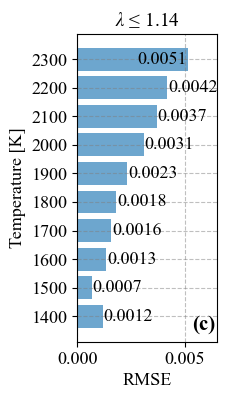

In [661]:
plt.rcParams['font.family'] = 'Times New Roman'  # For example, set font to Arial
plt.rcParams['font.size'] = 13  # 
fig, ax = plt.subplots(figsize=(1.8, 4))

bars = ax.barh(T[::-1],R2,color='C0',height=80,alpha=0.65)

xlabel=[0.00,0.005]
#ax.set_xticks(np.array(xlabel))
ax.set_xlim([0, 0.0065])
ylabel = [1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300]

ax.set_yticks(np.array(ylabel))
ax.text(0.82, 0.04, '(c)', transform=ax.transAxes,fontsize=font+2,fontfamily=fontfml, weight='bold')
ax.set_xlabel(r'RMSE')
ax.set_ylabel('Temperature [K]')
ax.xaxis.grid(True, linestyle='--', which='both', color='grey', alpha=.5)
ax.yaxis.grid(True, linestyle='--', which='both', color='grey', alpha=.5)
#plt.tight_layout()

# Annotate each bar with its value
i=0
for bar in bars:
    width = bar.get_width()
    if i>0:
        ax.text(width+0.0012,  # x position of the text
            bar.get_y() + bar.get_height() / 2,  # y position of the text
            f'{width:.4f}',  # value (formatted to 2 decimal places here)
            ha='center', va='center',fontsize=font,fontfamily=fontfml,
            color='black')
        
    else:
        ax.text(width-0.0012,  # x position of the text
            bar.get_y() + bar.get_height() / 2,  # y position of the text
            f'{width:.4f}',  # value (formatted to 2 decimal places here)
            ha='center', va='center',fontsize=font,fontfamily=fontfml,
            color='black')
    i+=1

fig_dir = "../figure/Fit_T_depth/"
ax.set_title(f'$\lambda$ ≤ {1/nu[0]*1e4:.2f}',fontsize=font+1)
fig.savefig(fig_dir+'fit_r2_lowT_sw.png', dpi=300, bbox_inches='tight',transparent=True)

plt.show()

In [598]:
mean_absolute_percentage_error([1,2], [1.1,2])

0.050000000000000044